In [1]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    x = cp.Variable(len(a))

    if metric == "sw":
        objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    elif (metric == "pf") or (metric == 1):
        objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
    elif metric == "mm":
        objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    else:
        y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
        objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))
               
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS", abstol=1e-6)

    user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
    surplus = np.sum(user_surplus)
    
    return problem.value, x.value, user_surplus, surplus


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]
    metric = params["metric"]
    xbar = params["xbar"]
    
    np.random.seed(seed)
    
    a = 1*np.random.rand(n_users) + 1
    b = xbar * a
    
    try:
        warnings.simplefilter("error")
        assert check_feasibility(L, a, b), "infeasible"
        val, sol, user_surplus, surplus = solve(L, a, b, metric)
        message = "success"

    except (Warning, TypeError, cp.SolverError) as e:
        val, sol, user_surplus, surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        message = str(e)
        
    return dict(
        n_users=n_users, seed=seed, metric=metric, message=message,
        a=a, b=b,val=val, sol=sol, user_surplus=user_surplus, surplus=surplus,
    )

In [3]:
params_list = [
    dict(L=L, n_users=n_users, seed=seed, metric=metric, xbar=2)
    for L in [1] for n_users in [10] for seed in range(1000)
    for metric in ["sw", "pf"]#np.linspace(0, 3, 51)[1:]
]

len(params_list)

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

In [4]:
df = pd.DataFrame(results)
df["a_rank"] = df.a.apply(lambda x: list(pd.Series(x).rank()))
df_sw = df.loc[df.metric=="sw"]
df_pf = df.loc[df.metric=="pf"]

a = np.array(df_sw.a.tolist())
rel_a = (a / a.max(1, keepdims=True)).flatten()

sw_sol = np.array(df_sw.sol.tolist()).flatten()
sw_surplus = np.array(df_sw.user_surplus.tolist()).flatten()

pf_sol = np.array(df_pf.sol.tolist()).flatten()
pf_surplus = np.array(df_pf.user_surplus.tolist()).flatten()

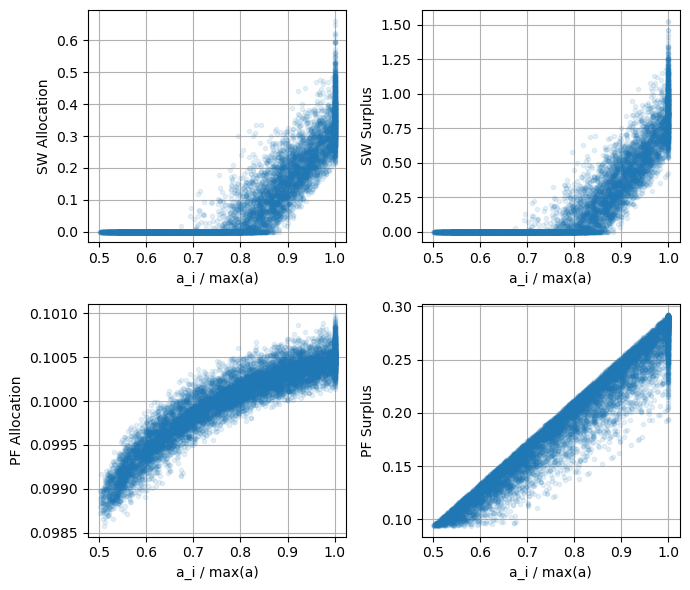

In [5]:
plt.figure(figsize=(7, 6))

plt.subplot(2, 2, 1)
plt.plot(rel_a, sw_sol, ".", alpha=0.1)
plt.xlabel("a_i / max(a)")
plt.ylabel("SW Allocation")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(rel_a, sw_surplus, ".", alpha=0.1)
plt.xlabel("a_i / max(a)")
plt.ylabel("SW Surplus")
plt.grid()


plt.subplot(2, 2, 3)
plt.plot(rel_a, pf_sol, ".", alpha=0.1)
plt.xlabel("a_i / max(a)")
plt.ylabel("PF Allocation")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(rel_a, pf_surplus, ".", alpha=0.1)
plt.xlabel("a_i / max(a)")
plt.ylabel("PF Surplus")
plt.grid()

plt.tight_layout()
plt.show()

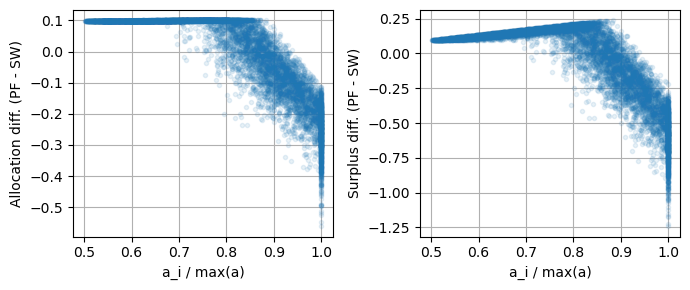

In [6]:


plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(rel_a, pf_sol - sw_sol, ".", alpha=0.1)
plt.xlabel("a_i / max(a)")
plt.ylabel("Allocation diff. (PF - SW)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(rel_a, pf_surplus - sw_surplus, ".", alpha=0.1)
plt.grid()
plt.xlabel("a_i / max(a)")
plt.ylabel("Surplus diff. (PF - SW)")

plt.tight_layout()
plt.show()

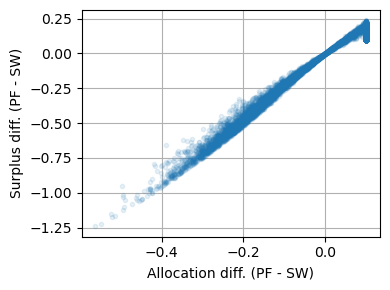

In [7]:
allocation_gain = pf_sol - sw_sol
surplus_gain = pf_surplus - sw_surplus

plt.figure(figsize=(4, 3))

plt.plot(allocation_gain, surplus_gain, ".", alpha=0.1)
plt.xlabel("Allocation diff. (PF - SW)")
plt.ylabel("Surplus diff. (PF - SW)")
plt.grid()

plt.tight_layout()
plt.show()

In [8]:
allocation_gain.mean(), surplus_gain.mean()

(-5.643449544817659e-10, -0.04486199105728815)

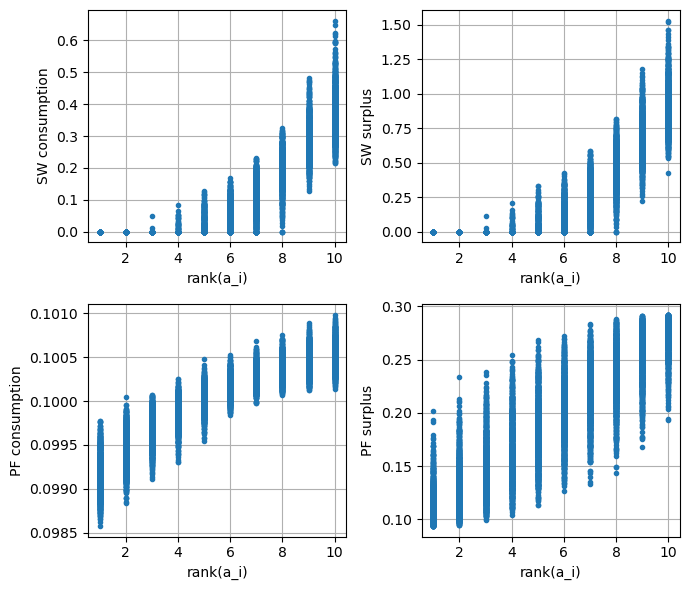

In [9]:
params_list = [
    dict(L=L, n_users=n_users, seed=seed, metric=metric, xbar=2)
    for L in [1] for n_users in [10] for seed in range(1000)
    for metric in ["sw", "pf"]#np.linspace(0, 3, 51)[1:]
]

len(params_list)

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

df = pd.DataFrame(results)
df["a_rank"] = df.a.apply(lambda x: list(pd.Series(x).rank()))
df = df.loc[df.metric=="sw"]

plt.figure(figsize=(7, 6))

plt.subplot(2, 2, 1)
plt.plot(
    np.array(df.a_rank.tolist()).flatten(),
    np.array(df.sol.tolist()).flatten(),
    "."
)
plt.xlabel("rank(a_i)")
plt.ylabel("SW consumption")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(
    np.array(df.a_rank.tolist()).flatten(),
    np.array(df.user_surplus.tolist()).flatten(),
    "."
)

plt.xlabel("rank(a_i)")
plt.ylabel("SW surplus")
plt.grid()


df = pd.DataFrame(results)
df["a_rank"] = df.a.apply(lambda x: list(pd.Series(x).rank()))
df = df.loc[df.metric=="pf"]

plt.subplot(2, 2, 3)
plt.plot(
    np.array(df.a_rank.tolist()).flatten(),
    np.array(df.sol.tolist()).flatten(),
    "."
)
plt.xlabel("rank(a_i)")
plt.ylabel("PF consumption")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(
    np.array(df.a_rank.tolist()).flatten(),
    np.array(df.user_surplus.tolist()).flatten(),
    "."
)

plt.xlabel("rank(a_i)")
plt.ylabel("PF surplus")
plt.grid()


plt.tight_layout()
#plt.plot(df.metric, df.surplus)

In [10]:
x_bar = 2

In [11]:
params_list = [
    dict(L=L, n_users=n_users, seed=seed, metric=metric, xbar=2)
    for L in [1] for n_users in [10] for seed in range(1000)
    for metric in ["sw", "pf"]#np.linspace(0, 3, 51)[1:]
]

len(params_list)

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

In [12]:
df = pd.DataFrame(results)
df["a_rank"] = df.a.apply(lambda x: list(pd.Series(x).rank()))
df_sw = df.loc[df.metric=="sw"]
df_pf = df.loc[df.metric=="pf"]

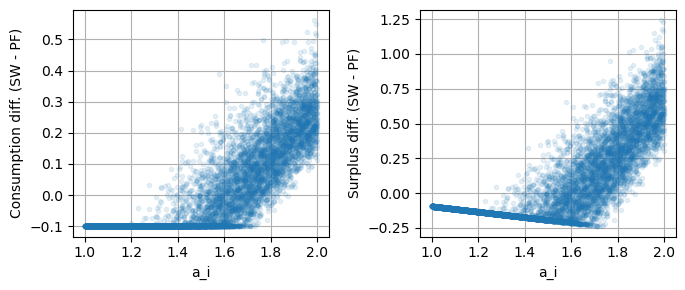

In [13]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(
    np.array(df_sw.a.tolist()).flatten(),
    np.array(df_sw.sol.tolist()).flatten() - np.array(df_pf.sol.tolist()).flatten(),
    ".", alpha=0.1
)
plt.xlabel("a_i")
plt.ylabel("Consumption diff. (SW - PF)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(
    np.array(df_sw.a.tolist()).flatten(),
    np.array(df_sw.user_surplus.tolist()).flatten() - np.array(df_pf.user_surplus.tolist()).flatten(),
    ".", alpha=0.1
)
plt.grid()
plt.xlabel("a_i")
plt.ylabel("Surplus diff. (SW - PF)")
# plt.grid()


plt.tight_layout()
#plt.plot(df_pf.metric, df_pf.surplus)

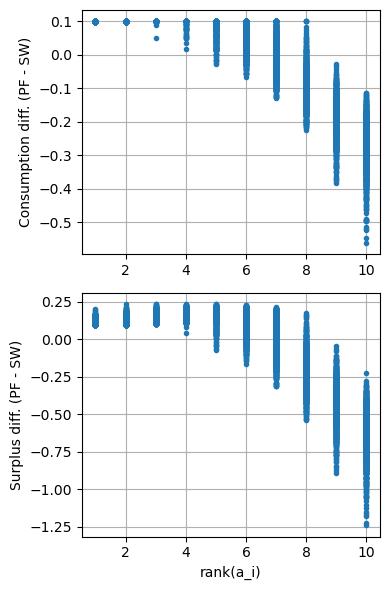

In [14]:
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.plot(
    np.array(df_sw.a_rank.tolist()).flatten(),
    np.array(df_pf.sol.tolist()).flatten() - np.array(df_sw.sol.tolist()).flatten(),
    "."
)
# plt.xlabel("rank(a_i)")
plt.ylabel("Consumption diff. (PF - SW)")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(
    np.array(df_sw.a_rank.tolist()).flatten(),
    np.array(df_pf.user_surplus.tolist()).flatten() - np.array(df_sw.user_surplus.tolist()).flatten(),
    "."
)
plt.grid()
plt.xlabel("rank(a_i)")
plt.ylabel("Surplus diff. (PF - SW)")

plt.tight_layout()plt.show()